Running with PyMC version: 5.22.0


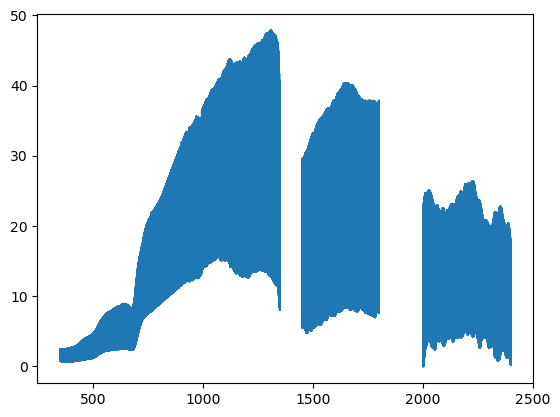

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import gaussian_kde, norm
import ipywidgets as widgets
from IPython.display import display, clear_output

print("Running with PyMC version:", pm.__version__)

data = pd.read_table(r"N:\isipd\projects\p_planetdw\data\methods_test\s2_outputs\SP026_ind-hypersp.tab")
data

plt.plot(data['Lambda [nm]'], data['Refl [%]'])

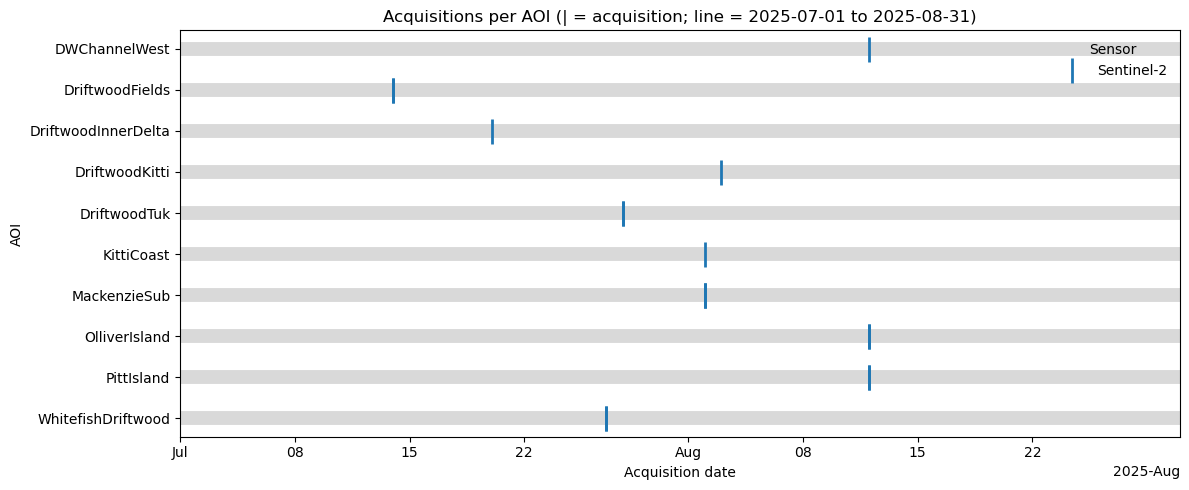

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Load ---
csv_path = "/isipd/projects/p_planetdw/data/methods_test/aois/S2_GEE_export_summary.csv"
df = pd.read_csv(csv_path)

# --- Parse/clean ---
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
# Make sure DateDeltaDays is numeric (used for Aerial offset)
df["DateDeltaDays"] = pd.to_numeric(df.get("DateDeltaDays", 0), errors="coerce").fillna(0)

# Infer Sensor if not present: detect AE, Aerial, then Sentinel-2
def infer_sensor(row):
    s = " ".join(str(row.get(c, "")) for c in ["ExportTask", "SystemIndex"]).upper()
    # Detect AE as a distinct sensor tag if present in identifiers
    if ("_AE" in s) or ("AE_" in s) or (" AE " in s):
        return "AE"
    if "AERIAL" in s:
        return "Aerial"
    if ("S2" in s) or ("SENTINEL-2" in s) or ("SENTINEL2" in s):
        return "Sentinel-2"
    return "Other"

if "Sensor" not in df.columns:
    df["Sensor"] = df.apply(infer_sensor, axis=1)

# --- Plot-time date for each row ---
# Sentinel-2 → use Date
# Aerial     → Date - DateDeltaDays
# AE         → use Date (change to minus offset as needed)
df["plot_date"] = df["Date"]
is_aerial = df["Sensor"].eq("Aerial") & df["Date"].notna()
df.loc[is_aerial, "plot_date"] = df.loc[is_aerial, "Date"] - pd.to_timedelta(df.loc[is_aerial, "DateDeltaDays"], unit="D")

# --- Window: fixed for all AOIs (2025-07-01 .. 2025-08-31) ---
window_start = pd.Timestamp("2025-07-01")
window_end   = pd.Timestamp("2025-08-31")

# Keep only markers that fall inside the window
df_plot = df[df["plot_date"].between(window_start, window_end)].copy()

# --- AOI layout ---
aoi_order = df["AOI"].dropna().drop_duplicates().tolist()
aoi_to_y = {aoi: i for i, aoi in enumerate(aoi_order)}

# --- Figure ---
fig_h = max(4, 0.5 * len(aoi_order))
fig, ax = plt.subplots(figsize=(12, fig_h))

# Light-grey 10-pt line for each AOI across the fixed window
for aoi in aoi_order:
    y = aoi_to_y[aoi]
    ax.hlines(y=y, xmin=window_start, xmax=window_end, color="lightgrey", linewidth=10, alpha=0.85, zorder=1)

# Colors per sensor (AE added with its own color)
sensor_colors = {
    "Sentinel-2": "#1f77b4",  # blue
    "Aerial": "#ff7f0e",      # orange
    "AE": "#2ca02c",          # green
    "Other": "#7f7f7f"        # grey
}

# Plot vertical '|' markers at acquisition times (inside window)
legend_done = set()
for _, row in df_plot.dropna(subset=["plot_date", "AOI"]).iterrows():
    y = aoi_to_y.get(row["AOI"])
    x = row["plot_date"]
    sensor = row.get("Sensor", "Other")
    color = sensor_colors.get(sensor, sensor_colors["Other"])
    label = sensor if sensor not in legend_done else "_nolegend_"

    ax.plot(
        x, y,
        marker="|",
        markersize=18,         # visual height of the bar
        markeredgewidth=2,     # thickness of the '|'
        linestyle="None",
        markerfacecolor="none",
        markeredgecolor=color,
        zorder=3,
        label=label
    )
    legend_done.add(sensor)

# --- Axes/formatting ---
ax.set_yticks([aoi_to_y[a] for a in aoi_order])
ax.set_yticklabels(aoi_order)
ax.invert_yaxis()  # optional

ax.set_xlim(window_start, window_end)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

ax.set_xlabel("Acquisition date")
ax.set_ylabel("AOI")
ax.set_title("Acquisitions per AOI (| = acquisition; line = 2025-07-01 to 2025-08-31)")

handles, labels = ax.get_legend_handles_labels()
if labels:
    ax.legend(handles, labels, title="Sensor", loc="upper right", frameon=False)

plt.tight_layout()
plt.show()


In [7]:
channel_list = [True, True, True, True]

input_channels = list(range(len(channel_list)))
label_channel = len(channel_list)  # label directly after inputs

print(input_channels, label_channel)

[0, 1, 2, 3] 4


In [2]:
unet_macs_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples'
swin_macs_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples'

unet_ps_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ps_samples'
swin_ps_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ps_samples'

metrics = ['loss', 'specificity', 'sensitivity', 'IoU', 'f1_score', 'Hausdorff_distance']
maximize_metrics = {'specificity', 'sensitivity', 'IoU', 'f1_score'}

unet_macs_output_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples'
swin_macs_output_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples'

In [3]:
def read_metrics_as_array(directory, metrics):
    files = sorted([f for f in os.listdir(directory) if f.endswith('.csv')])
    data_list = []
    
    metric_names = []
    for metric in metrics:
        metric_names.append(metric)
        metric_names.append('val_' + metric)

    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        file_data = []

        for name in metric_names:
            if name in df.columns:
                file_data.append(df[name].values)
            else:
                # Fill with NaNs if column is missing
                file_data.append(np.full(len(df), np.nan))
        
        # Transpose so shape is (epochs, metrics)
        file_data = np.stack(file_data, axis=1)  # shape: (epochs, num_metrics)
        data_list.append(file_data)

    # Convert to a 3D array: (files, epochs, metrics)
    data_array = np.stack(data_list, axis=0)

    # Build lookup dict
    lookup = {name: idx for idx, name in enumerate(metric_names)}

    return data_array, lookup, files


In [4]:
def plot_losses(loss_array, metrics, metric_lookup, output_dir, show_plot=False):
    epochs = loss_array.shape[1]
    num_metrics = len(metrics)

    plt.figure(figsize=(20, 2.5))  # Square layout
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, i + 1)

        # Training metric
        for j in range(loss_array.shape[0]):
            plt.plot(range(epochs), loss_array[j, :, metric_lookup[metric]], color='lightblue', linewidth=1)

        train_mean = np.nanmean(loss_array[:, :, metric_lookup[metric]], axis=0)
        
        # Validation metric
        val_metric = 'val_' + metric
        if val_metric in metric_lookup:
            for j in range(loss_array.shape[0]):
                plt.plot(range(epochs), loss_array[j, :, metric_lookup[val_metric]], color='peachpuff', linewidth=1)

            val_mean = np.nanmean(loss_array[:, :, metric_lookup[val_metric]], axis=0)
            plt.plot(range(epochs), train_mean, color='tab:blue', label=f'train', linewidth=2)
            plt.plot(range(epochs), val_mean, color='tab:orange', label=f'val', linewidth=2)

        plt.title(metric)
        plt.ylim(0,1)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        #plt.legend(loc='upper right')
        plt.grid(True)
        plt.gca().set_aspect('auto')  # Square plot per metric (approx)
    
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'losses_plot.png')
    plt.savefig(output_path)
    if show_plot:
        plt.show()
    plt.close()
    print(f"Plot saved to {output_path}")




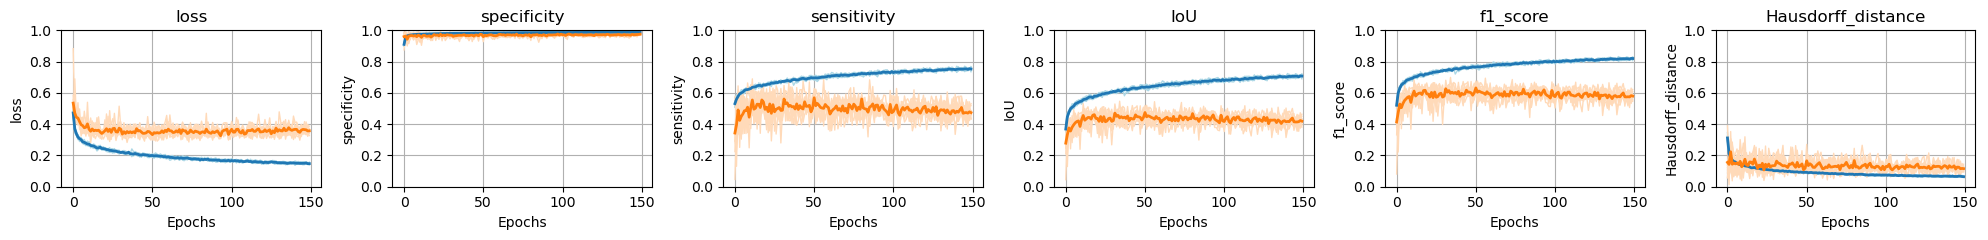

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples\losses_plot.png


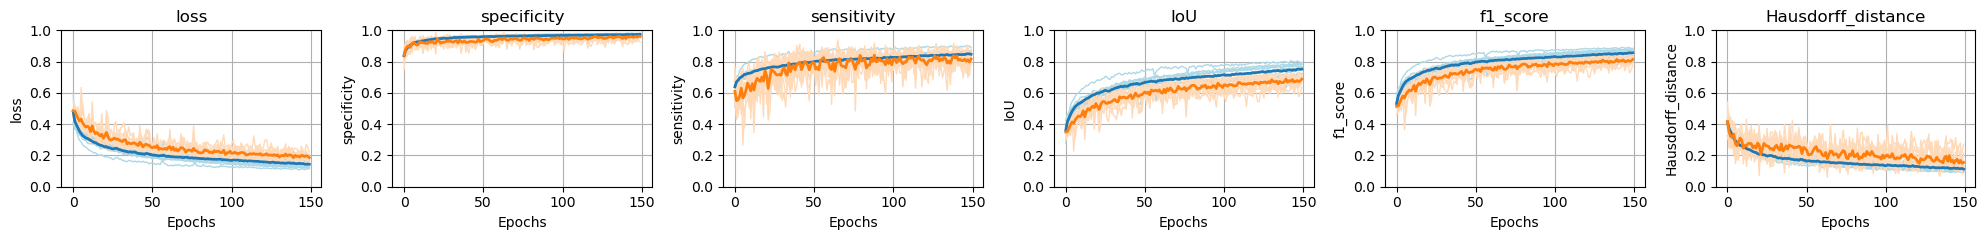

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples\losses_plot.png


C:\Users\castad001\AppData\Local\Temp\ipykernel_10648\3993307321.py:14: RuntimeWarning: Mean of empty slice
  train_mean = np.nanmean(loss_array[:, :, metric_lookup[metric]], axis=0)


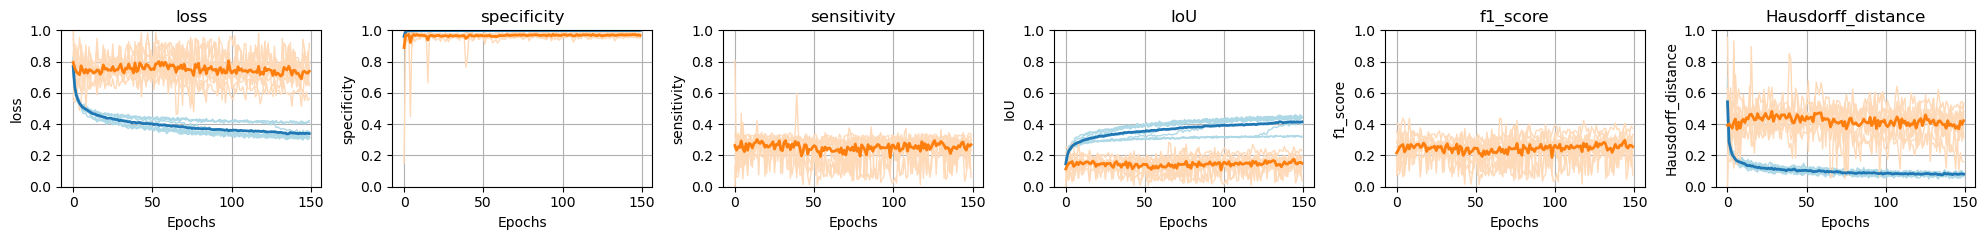

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ps_samples\losses_plot.png


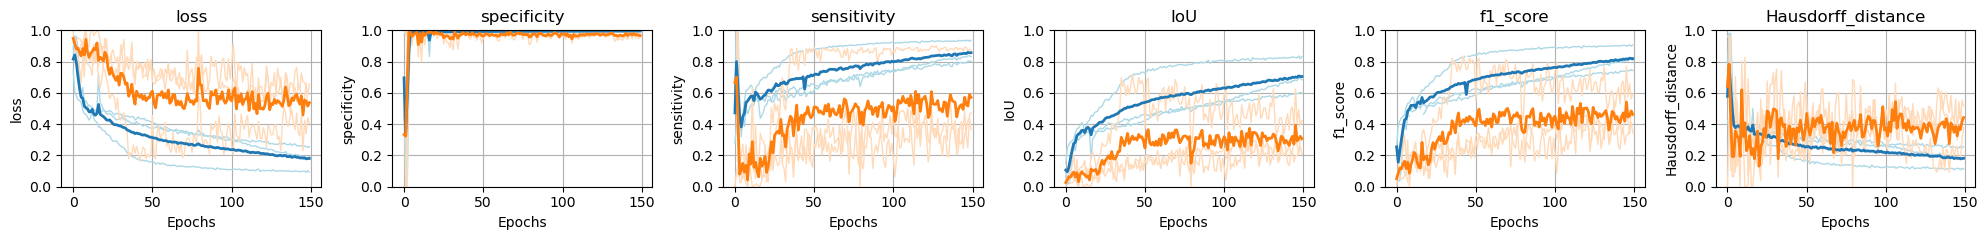

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ps_samples\losses_plot.png


In [7]:
unet_macs, unet_macs_metric_lookup, unet_macs_file_names = read_metrics_as_array(unet_macs_loss_dir, metrics)
swin_macs, swin_macs_metric_lookup, swin_macs_file_names = read_metrics_as_array(swin_macs_loss_dir, metrics)
unet_ps, unet_ps_metric_lookup, unet_ps_file_names = read_metrics_as_array(unet_ps_loss_dir, metrics)
swin_ps, swin_ps_metric_lookup, swin_ps_file_names = read_metrics_as_array(swin_ps_loss_dir, metrics)

plot_losses(unet_macs, metrics, unet_macs_metric_lookup, unet_macs_output_dir, show_plot=True)
plot_losses(swin_macs, metrics, swin_macs_metric_lookup, swin_macs_output_dir, show_plot=True)
plot_losses(unet_ps, metrics, unet_ps_metric_lookup, unet_ps_loss_dir, show_plot=True)
plot_losses(swin_ps, metrics, swin_ps_metric_lookup, swin_ps_loss_dir, show_plot=True)

In [8]:
def get_best_metric(data_array, metric_lookup, metric):
    """
    Get the best metric values across epochs for each file in the data array.
    Args:
        data_array (np.ndarray): 3D array of shape (files, epochs, metrics).
        metric_lookup (dict): Dictionary mapping metric names to their indices.
        metric (str): The metric to evaluate.
        maximize_metrics (set): Set of metrics that should be maximized.
    Returns:
        np.ndarray: Array of best metric values for each file.
    """

    best_values = []


    for i in range(data_array.shape[0]):

        losses = data_array[i, :, metric_lookup['loss']]
        values = data_array[i, :, metric_lookup[metric]]


        best_epoch = np.nanargmin(losses)
        #print(f'best epoch; {best_epoch}')

        best_value = values[best_epoch]
        #print('best value:', best_value)

        best_values.append(best_value)

    return np.array(best_values)

def interpret_bayes_factor(bf):
    """Return Jeffreys-style verbal label for a Bayes factor > 1."""
    if bf < 3:
        return "anecdotal"
    elif bf < 10:
        return "moderate"
    elif bf < 30:
        return "strong"
    elif bf < 100:
        return "very strong"
    else:
        return "extreme"

def BEST(combined_array, group_one, group_two, metric, minimal_metrcis = ['val_loss', 'loss', 'val_Hausdorff_distance', 'Hausdorff_distance'], group_one_label='unet', group_two_label='swin', plot=True):

    """
    Perform Bayesian estimation of the difference in means and standard deviations
    between two groups using Student's t-distribution (Krischke 2005).
    Args:
        combined_array (pd.DataFrame): DataFrame containing the metric values and group labels.
        group_one (np.ndarray): values of group 1.
        group_two (np.ndarray): values of group 2.
    Returns:
        None
    """
    metric_values = combined_array[metric].values

    mu_m = metric_values.mean()
    mu_s = metric_values.std()*2

    sigma_low = 10**-1
    sigma_high = 10

    with pm.Model() as model:
        group1_mean = pm.Normal(f'{group_one_label}_mean', mu=mu_m, sigma=mu_s)
        group2_mean = pm.Normal(f'{group_two_label}_mean', mu=mu_m, sigma=mu_s)

        group1_std = pm.Uniform(f'{group_one_label}_std', lower=sigma_low, upper=sigma_high)
        group2_std = pm.Uniform(f'{group_two_label}_std', lower=sigma_low, upper=sigma_high)

        nu_minus_one = pm.Exponential('nu_minus_one', lam=1/29)
        nu = pm.Deterministic('nu', nu_minus_one + 1)
        nu_log10 = pm.Deterministic('nu_log10', np.log10(nu))

        lambda_group1 = group1_std**-2
        lambda_group2 = group2_std**-2

        group_one_obs = pm.StudentT(f'{group_one_label}_obs', mu=group1_mean, lam=lambda_group1, nu=nu, observed=group_one)
        group_two_obs = pm.StudentT(f'{group_two_label}_obs', mu=group2_mean, lam=lambda_group2, nu=nu, observed=group_two)

        diff_of_means = pm.Deterministic('diff_of_means', group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic('diff_of_stds', group1_std - group2_std)
        effect_size = pm.Deterministic('effect_size', diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

        idata = pm.sample(tune=1000, draws=2000, chains=4, target_accept=0.95, return_inferencedata=True)

    if plot:
        print('\n---- Posterior for the means and stds ----')

        az.plot_posterior(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean', f'{group_one_label}_std', f'{group_two_label}_std', 'nu_log10', 'nu'])
        plt.show()

        print('\n---- Posterior for the differences and effect size ----')

        az.plot_posterior(idata, var_names=['diff_of_means', 'diff_of_stds', 'effect_size'], ref_val=0)
        plt.show()

        print('\n---- Forests for means, stds, and nu ----')
        
        az.plot_forest(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean'])
        plt.show()

        print('\n---- Forests for stds and nu ----')

        az.plot_forest(idata, var_names=[f'{group_one_label}_std', f'{group_two_label}_std', 'nu'])
        plt.show()

    print('\n---- Model summary ----')

    summary = az.summary(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean','diff_of_means', 'diff_of_stds', 'effect_size'])
    print(summary)

    print('\n---- Savage-Dickey Bayes Factor ----\n')

    
    # Posterior density at δ = 0  (KDE is still appropriate here)
    diff_samples = idata.posterior['diff_of_means'].values.flatten()
    posterior_kde            = gaussian_kde(diff_samples)
    posterior_density_at_zero = posterior_kde.evaluate(0)[0]

    # Analytical prior density at δ = 0  (δ ~ Normal(0, √2·mu_s))
    prior_sd_diff            = np.sqrt(2) * mu_s
    prior_density_at_zero    = norm.pdf(0, loc=0, scale=prior_sd_diff)

    # Bayes factors
    BF_01 = posterior_density_at_zero / prior_density_at_zero   # H₀ over H₁
    BF_10 = 1 / BF_01                                           # H₁ over H₀

    metric_is_lower_better = metric  in minimal_metrcis
    mean_diff = diff_samples.mean()   # μ_unet − μ_swin

    if BF_10 > 1:            # data support the alternative
        # who wins, given the metric direction?
        if (not metric_is_lower_better and mean_diff > 0) or \
        (    metric_is_lower_better and mean_diff < 0):
            winner, loser = group_one_label, group_two_label
        else:
            winner, loser = group_two_label, group_one_label

        label = interpret_bayes_factor(BF_10)
        print(f"p(δ=0)        : {prior_density_at_zero:.4g}")
        print(f"p(δ=0 | data) : {posterior_density_at_zero:.4g}")
        print(f"Evidence for {winner} outperforming {loser}: "
            f"BF₁₀ = {BF_10:.4g}  ({label})\n")

    else:                     # data support the null
        label = interpret_bayes_factor(BF_01)
        print(f"p(δ=0)        : {prior_density_at_zero:.4g}")
        print(f"p(δ=0 | data) : {posterior_density_at_zero:.4g}")
        print(f"Evidence for no difference (H₀): "
            f"BF₀₁ = {BF_01:.4g}  ({label})")


[0.3812412  0.38870388 0.47546616 0.44583207 0.47902238 0.44609573
 0.45814842 0.43761808 0.44007346 0.41527733]


C:\Users\castad001\AppData\Local\Temp\ipykernel_10648\2989344593.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


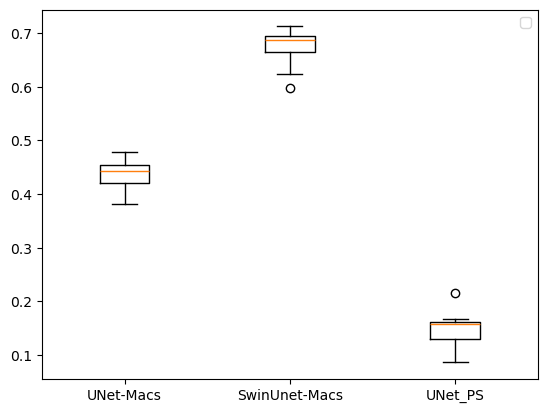

In [9]:
full_metric = 'val_IoU'

unet_macs_best = get_best_metric(unet_macs, unet_macs_metric_lookup, full_metric)
swin_macs_best = get_best_metric(swin_macs, swin_macs_metric_lookup, full_metric)

unet_ps_best = get_best_metric(unet_ps, unet_ps_metric_lookup, full_metric)
print(unet_macs_best)

plt.boxplot([unet_macs_best, swin_macs_best, unet_ps_best], tick_labels=['UNet-Macs', 'SwinUnet-Macs', 'UNet_PS'], showfliers=True)
plt.legend()
plt.show()

In [10]:
tabs     = []      # the Output widgets (one per metric)
tab_titles = []    # used to label the tab headers

for metric in metrics:

    full_metric = 'val_' + metric if not metric.startswith('val_') else metric
    out = widgets.Output()          # each metric gets its own Output “sandbox”

    with out:                       # everything inside goes only to this tab
        clear_output(wait=True)     # keeps the tab clean on reruns

        print(f"### Processing metric: {full_metric}\n")

        unet_macs_best = get_best_metric(unet_macs, unet_macs_metric_lookup, full_metric)
        swin_macs_best = get_best_metric(swin_macs, swin_macs_metric_lookup, full_metric)

        #plt.boxplot([unet_best, swin_best], labels=['UNet', 'Swin Transformer'], showfliers=True)



        BEST(
            pd.concat([
                pd.DataFrame({full_metric: unet_best, 'group': 'U-Net | Aerial'}),
                pd.DataFrame({full_metric: swin_best, 'group': 'Swin U-Net | Aerial'}),
            ]).reset_index(drop=True),
            unet_best, swin_best, full_metric,
            plot=True                                    
        )

    # keep references so we can build the Tab afterwards
    tabs.append(out)
    tab_titles.append(full_metric)

tab_widget = widgets.Tab(children=tabs)

for i, title in enumerate(tab_titles):
    tab_widget.set_title(i, title)   # label each tab

display(tab_widget)


In [11]:
import os
import json
from pathlib import Path
from collections import defaultdict

def filter_and_remap_splits(folder_src: str,
                            folder_dst: str,
                            split_dict: dict) -> dict:
    """
    • Walk through *every file* in `folder_src` (sorted for determinism).
    • If that file also exists in `folder_dst`, look up:
        – its index in the *source* folder
        – the split group (train / test / val) that index belongs to
        – its index in the *destination* folder
    • Append the destination index to a new list under the same split group.
    • Any file missing from `folder_dst` is silently skipped.

    Returns
    -------
    dict  –  same keys as `split_dict`, but containing only the
             files that still exist in both folders, with indices
             now referring to `folder_dst`.
    """

   
    # Sorted listings give stable, reproducible indices
    src_files = sorted(os.listdir(folder_src))
    dst_files = sorted(os.listdir(folder_dst))

    # Fast filename ➜ index lookup for folder_dst
    dst_index_of = {name: i for i, name in enumerate(dst_files)}

    # Prepare the output dict with the same split keys
    updated = {k: [] for k in split_dict}

    for group, idx_list in split_dict.items():
        for idx in idx_list:
            if idx >= len(src_files):
                raise IndexError(
                    f"Index {idx} is out of range for source folder "
                    f"({len(src_files)} files)."
                )
            fname = src_files[idx]            # step 1
            dst_idx = dst_index_of.get(fname) # step 2
            if dst_idx is not None:
                updated[group].append(dst_idx)  # step 3

    return updated


# ---------------------------------------------------------------------------
# Example usage
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    # ── folders ────────────────────────────────────────────────────────────
    FOLDER_A = r"N:\isipd\projects\p_planetdw\data\methods_test\training_data\MACS\20250429-1208_MACS_test_utm8"   # indices in the JSON point here
    FOLDER_B = r"N:\isipd\projects\p_planetdw\data\methods_test\training_data\PS\20250604-0816_Unet_Planet_utm8"   # new target folder

    # ── your JSON split definition (load from file or paste) ───────────────
    SPLITS_JSON = """
    {
    "training_frames": [550, 28, 374, 15, 134, 462, 193, 112, 544, 341, 582, 513, 385, 24, 263, 347, 452, 249, 6, 623, 285, 11, 195, 105, 632, 608, 237, 570, 315, 143, 220, 475, 640, 625, 432, 149, 226, 402, 202, 451, 620, 255, 499, 288, 401, 246, 369, 360, 334, 345, 595, 316, 319, 168, 225, 581, 245, 63, 536, 624, 508, 503, 540, 408, 291, 426, 96, 657, 434, 375, 86, 478, 548, 524, 419, 188, 151, 37, 217, 328, 596, 407, 161, 532, 250, 318, 652, 42, 353, 39, 472, 384, 313, 493, 569, 448, 92, 70, 101, 5, 382, 3, 630, 209, 443, 234, 206, 546, 45, 644, 290, 79, 163, 264, 575, 517, 441, 587, 424, 303, 157, 591, 122, 450, 329, 572, 147, 456, 376, 483, 178, 592, 423, 377, 387, 230, 605, 236, 551, 491, 571, 75, 85, 626, 396, 616, 260, 169, 277, 185, 446, 431, 390, 90, 258, 467, 46, 340, 265, 281, 110, 29, 633, 386, 504, 490, 152, 357, 509, 205, 336, 476, 227, 97, 22, 647, 177, 515, 166, 114, 266, 180, 184, 604, 395, 354, 651, 398, 123, 567, 106, 634, 203, 58, 153, 447, 656, 321, 663, 496, 454, 224, 461, 4, 218, 528, 299, 19, 140, 179, 103, 223, 181, 113, 137, 530, 615, 573, 599, 421, 57, 568, 404, 389, 327, 50, 425, 267, 350, 485, 74, 397, 391, 338, 502, 403, 415, 579, 331, 221, 138, 637, 470, 642, 361, 229, 172, 409, 459, 55, 576, 111, 636, 535, 139, 622, 62, 135, 9, 132, 469, 545, 482, 487, 199, 593, 65, 192, 339, 500, 588, 17, 141, 44, 323, 435, 413, 439, 521, 284, 533, 175, 484, 658, 427, 643, 73, 486, 272, 349, 366, 373, 510, 531, 2, 1, 607, 216, 378, 631, 578, 242, 333, 165, 159, 392, 543, 549, 405, 312, 231, 370, 279, 102, 442, 116, 198, 38, 298, 52, 89, 617, 465, 81, 358, 522, 213, 26, 99, 562, 317, 553, 297, 614, 32, 489, 586, 668, 8, 94, 48, 160, 274, 14, 296, 16, 628, 367, 606, 326, 268, 144, 598, 121, 259, 474, 344, 270, 444, 372, 66, 660, 77, 83, 87, 262, 278, 10, 602, 257, 43, 93, 308, 563, 594, 523, 302, 115, 537, 650, 449, 239, 453, 21, 330, 519, 207, 34, 210, 150, 35, 301, 211, 31, 0, 219, 240, 414, 359, 639, 68, 351, 468, 190, 394, 365, 649, 379, 171, 148, 648, 269, 458, 305, 182, 618, 20, 584, 64, 556, 547, 53, 343, 12, 346, 154, 383, 56], 
    "testing_frames": [363, 36, 506, 557, 534, 455, 322, 155, 129, 589, 645, 238, 82, 654, 481, 418, 538, 183, 337, 311, 512, 310, 60, 107, 612, 514, 635, 276, 108, 186, 156, 201, 67, 80, 309, 460, 411, 295, 558, 662, 23, 282, 488, 664, 494, 388, 125, 477, 164, 516, 580, 69, 133, 552, 54, 286, 554, 638, 585, 368, 59, 320, 495, 27, 248, 241, 98, 560, 212, 146, 197, 208, 583, 564, 293, 518, 243, 566, 542, 232, 30, 300, 275, 173, 406, 306, 646, 204, 41, 287, 214, 501, 256, 422, 601, 292, 84, 565, 127, 136, 215, 466, 273, 420, 176, 457, 665, 667, 91, 235, 49, 539, 289, 283, 417, 603, 440, 142, 100, 429, 170, 352, 600, 348, 233, 124, 399, 117, 72, 381, 362, 520, 194, 597], 
    "validation_frames": [438, 78, 613, 332, 511, 244, 464, 471, 393, 167, 128, 661, 356, 355, 410, 364, 88, 47, 247, 109, 187, 611, 497, 436, 251, 574, 555, 619, 254, 40, 473, 335, 228, 126, 95, 119, 314, 33, 641, 61, 609, 527, 200, 191, 7, 412, 145, 621, 158, 463, 561, 610, 196, 222, 400, 653, 480, 120, 445, 130, 577, 380, 629, 304, 294, 498, 479, 430, 526, 590, 559, 51, 71, 325, 261, 13, 307, 252, 342, 162, 131, 18, 25, 416, 627, 428, 666, 507, 505, 529, 371, 118, 492, 541, 271, 659, 433, 324, 104, 437, 525, 189, 655, 76, 280, 253, 174]
    }
    """
    splits = json.loads(SPLITS_JSON)

    # ── remap & show the result ────────────────────────────────────────────
    updated = filter_and_remap_splits(FOLDER_A, FOLDER_B, splits)
    print(json.dumps(updated, indent=2))


{
  "training_frames": [
    0,
    14,
    40,
    20,
    6,
    11,
    36,
    9,
    26,
    34,
    15,
    2,
    16,
    4,
    7,
    17,
    38,
    33,
    43,
    48,
    37,
    35,
    30,
    8,
    28,
    27,
    21
  ],
  "testing_frames": [
    22,
    3,
    47,
    24,
    13,
    44,
    31,
    39,
    25,
    45
  ],
  "validation_frames": [
    41,
    1,
    29,
    19,
    23,
    12
  ]
}


In [12]:
def fit_bayesian_anova(df, metric, lower_is_better=False,
                       robust=True, hierarchical=True,
                       tune=1000, draws=2000, chains=4, target_accept=0.95):
    """
    df must have columns;  metric (float)  and  "group" (categorical/string)
    """
    y      = df[metric].values
    groups = df["group"].astype("category")
    g_idx  = groups.cat.codes.values          # 0 … K-1
    K      = int(g_idx.max() + 1)

    mu_m, mu_s        = y.mean(), y.std()*2
    sigma_low, sigma_high = 1e-1, 10

    with pm.Model() as m:
        # --- priors on the K group means -----------------------------------
        if hierarchical:          # partial-pooling variant
            mu_grand = pm.Normal("mu_grand", mu=mu_m, sigma=mu_s)
            tau       = pm.HalfNormal("tau", sigma=mu_s)
            mu        = pm.Normal("mu", mu=mu_grand, sigma=tau, shape=K)
        else:                     # independent means
            mu = pm.Normal("mu", mu=mu_m,  sigma=mu_s, shape=K)

        # --- priors on the K group stds ------------------------------------
        sigma = pm.Uniform("sigma", lower=sigma_low, upper=sigma_high, shape=K)

        # --- optional heavy-tailed likelihood ------------------------------
        nu = (pm.Exponential("nu_minus_1", 1/29) + 1) if robust else np.inf

        pm.StudentT("obs", mu=mu[g_idx], sigma=sigma[g_idx], nu=nu, observed=y)

        idata = pm.sample(tune=tune, draws=draws, chains=chains, target_accept=target_accept,
                          return_inferencedata=True)

    idata.attrs["metric"]           = metric
    idata.attrs["lower_is_better"]  = lower_is_better
    idata.attrs["groups"]           = groups.cat.categories.tolist()
    return idata

def prob_each_is_best(idata):
    """
    Return a Series whose index is group names and whose values are the
    posterior probabilities that each group has the best (min / max) mean.
    Works without the 'bottleneck' package.
    """
    metric_is_lower = idata.attrs["lower_is_better"]
    means = (
        idata.posterior["mu"]
        .stack(sample=("chain", "draw"))
        .values                              # numpy (K, N)
    )

    # index of best group in every posterior draw ---------------------------
    best_idx = means.argmin(axis=0) if metric_is_lower else means.argmax(axis=0)

    K   = means.shape[0]
    p   = np.bincount(best_idx, minlength=K) / best_idx.size  # length-K vector
    return pd.Series(p, index=idata.attrs["groups"], name="p(best)")


def pairwise_contrasts(idata, rope=None):
    means = (idata.posterior["mu"]
             .stack(sample=("chain", "draw"))
             .values)            # -> plain (K, N) ndarray
    K, N = means.shape
    names = idata.attrs["groups"]
    rows = []

    for i in range(K - 1):
        for j in range(i + 1, K):
            diff = means[i] - means[j]                # 1-D NumPy
            hdi_low, hdi_high = np.quantile(diff, [0.025, 0.975])
            prob_gt0 = (diff > 0).mean()

            row = dict(A=names[i], B=names[j],
                       mean_diff=diff.mean(),
                       hdi_low=hdi_low, hdi_high=hdi_high,
                       p_A_gt_B=prob_gt0)

            if rope is not None:
                row["p_in_rope"] = ((rope[0] < diff) & (diff < rope[1])).mean()
            rows.append(row)

    return pd.DataFrame(rows)



In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd

group_data = {
    "U-Net | Aerial": (unet_macs, unet_macs_metric_lookup),
    "U-Net | PS" : (unet_ps,   unet_ps_metric_lookup),
    "Swin U-Net | Aerial": (swin_macs,  swin_macs_metric_lookup),
    "Swin U-Net | PS": (swin_ps, swin_ps_metric_lookup),
           # add more …
    # "rest": (rest_data_array,  rest_metric_lookup),
}


minimal_metrics = {
    "val_loss", "loss",
    "val_Hausdorff_distance", "Hausdorff_distance",
}

# convenience ----------------------------------------------------------------
def best_per_group(metric_name):
    """Return a dict {group_name: 1-D array of best values (one per run)}."""
    out = {}
    for g, (arr, lookup) in group_data.items():
        out[g] = get_best_metric(arr, lookup, metric_name)
    return out


# ------------------------------------------------------------------
# 2.  One tab per metric
# ------------------------------------------------------------------
tabs, tab_titles = [], []

for metric in metrics:
    full_metric = (
        "val_" + metric 
    )
    box = widgets.Output()                 # 

    with box:
        clear_output(wait=True)
        print(f"### Processing metric: {full_metric}\n")

        # --- gather the “best epoch” values for all groups -----------
        best = best_per_group(full_metric)           # dict of 1-D arrays

        # --- quick exploratory box-plot ------------------------------
        plt.boxplot(best.values(), tick_labels=best.keys(), showfliers=True)
        plt.title(full_metric)
        plt.show()

        # --- tidy dataframe for the model ----------------------------
        df = pd.concat(
            [pd.DataFrame({full_metric: v, "group": k})
             for k, v in best.items()],
            ignore_index=True,
        )

        print(df)

        # --- run the Bayesian ANOVA model ----------------------------
        idata = fit_bayesian_anova(
            df, full_metric,
            lower_is_better=full_metric in minimal_metrics,
            hierarchical=True,            # or False if you prefer
            robust=True,
        )

        # --- 2a.   Which group is most likely best? ------------------
        print("\nPosterior probability each group is the best:")
        display(prob_each_is_best(idata).sort_values(ascending=False))

        # --- 2b.   Credible differences / Bayes factors --------------
        print("\nPair-wise contrasts (95 % HDI and p):")
        display(pairwise_contrasts(idata, rope=[-0.005, 0.005]))

        # --- optional visuals ----------------------------------------
        az.plot_forest(idata, var_names="mu")
        plt.title(f"{full_metric} – group means with 95 % HDI")
        plt.show()

        az.plot_posterior(idata, var_names="mu", ref_val=0)
        plt.title(f"{full_metric} – posteripr for group means with 95 % HDI")
        plt.show()

    # keep handles so we can build the tab view afterwards
    tabs.append(box)
    tab_titles.append(full_metric)


# ------------------------------------------------------------------
# 3.  Assemble the interactive widget
# ------------------------------------------------------------------
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(tab_titles):
    tab_widget.set_title(i, title)
display(tab_widget)


In [11]:
import json

path = r'/isipd/projects/p_planetdw/data/methods_test/logs/unet_tuning/20251024-113444_unet_tuning_HB_best_hparams.json'

open(path):
    file = json(path)
    print(file)

SyntaxError: invalid syntax (3361590141.py, line 5)

In [ ]:
# === 3D flight snapshots — UTM 4N, point-cloud (RGB+DEM) ground, VE, trail colored by altitude ===
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import fiona
from pyproj import CRS, Transformer
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import math

# --------------------------- knobs ---------------------------
VERT_EXAG = 5         # vertical exaggeration (>=1)
VIEW_ELEV = 28           # camera elevation (deg)
VIEW_AZIM = -100         # camera azimuth (deg)
DRAW_NORTH_ARROW = True  # overlay a 2D north arrow
SNAPSHOT_FREQ = "30S"     # frame cadence
OUT_DPI = 500            # PNG dpi
DEBUG_PRINT = False      # set True to print shapes/ranges once

# point cloud sampling
PC_TARGET_RES_M = 1.0    # reproject rasters to this pixel size (m)
PC_STEP = 5              # sample every N pixels (1 => every meter)
PC_MAX_POINTS = 2_000_000
PC_MARKER_SIZE = 0.1     # scatter size (points)

EPSG_UTM4N = 32604       # UTM zone 4N (meters)

# --------------------------- IO paths ---------------------------
GPKG_PATH = r"P:/cstadie/track_selawik2.gpkg"
IMAGE_PATH = r"N:\response\RS_imagery\MACS\PermaX_2024\data_products\WA_SelawikSlump_20240711_15cm_01\WA_SelawikSlump_20240711_15cm_01_Ortho.tif"   # RGB/RGBA GeoTIFF
DEM_PATH   = r"N:\response\RS_imagery\MACS\PermaX_2024\data_products\WA_SelawikSlump_20240711_15cm_01\WA_SelawikSlump_20240711_15cm_01_DSM.tif"     # DEM GeoTIFF
OUT_DIR    = r"P:/cstadie/snapshots_30s_pc"

# --------------------------- helpers ---------------------------
def read_track_with_fiona(gpkg_path: str | Path, layer: str | None = None,
                          time_format: str | None = None) -> pd.DataFrame:
    """Read a GPKG with Fiona, extract Point coords + fields to a DataFrame (UTM4N)."""
    gpkg_path = Path(gpkg_path)
    rows = []
    with fiona.open(gpkg_path, layer=layer) as src:
        if src.crs_wkt:
            src_crs = CRS.from_wkt(src.crs_wkt)
        elif src.crs:
            src_crs = CRS.from_user_input(src.crs)
        else:
            src_crs = CRS.from_epsg(4326)

        to_utm = Transformer.from_crs(src_crs, CRS.from_epsg(EPSG_UTM4N), always_xy=True)
        to_wgs84 = Transformer.from_crs(src_crs, CRS.from_epsg(4326), always_xy=True)

        for feat in src:
            geom = feat.get("geometry")
            if not geom or geom.get("type") != "Point":
                continue
            lon_src, lat_src = map(float, geom["coordinates"][:2])
            lon, lat = to_wgs84.transform(lon_src, lat_src)
            x_utm, y_utm = to_utm.transform(lon_src, lat_src)

            p = feat.get("properties", {}) or {}
            rows.append({
                "lon": lon, "lat": lat,
                "x_utm": x_utm, "y_utm": y_utm,
                "UTCTime": p.get("UTCTime"),
                "H-MSL": p.get("H-MSL"),
                "Roll": p.get("Roll"),
                "Stati": p.get("Stati"),
            })

    if not rows:
        raise ValueError("No Point features found in the specified layer/file.")

    df = pd.DataFrame(rows)

    # time -> datetime64[ns]
    if time_format:
        df["UTCTime"] = pd.to_datetime(df["UTCTime"], format=time_format, errors="coerce")
    else:
        df["UTCTime"] = pd.to_datetime(df["UTCTime"], errors="coerce")
    df = df.dropna(subset=["UTCTime"]).reset_index(drop=True)
    df["UTCTime"] = df["UTCTime"].astype("datetime64[ns]")

    # numeric fields
    for col in ["H-MSL", "Roll", "Stati"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # chronological order (stable)
    df = df.sort_values(["UTCTime", "Stati"], kind="mergesort").reset_index(drop=True)
    return df


def build_segments(df: pd.DataFrame):
    """Build 3D flight-line segments in UTM4N, breaking at 'Stati' gaps (no bridging)."""
    x = df["x_utm"].to_numpy(float)
    y = df["y_utm"].to_numpy(float)
    z = df["H-MSL"].to_numpy(float)
    stati = df["Stati"].to_numpy(float)

    stati_diff = np.empty_like(stati); stati_diff[:] = np.nan
    stati_diff[1:] = stati[1:] - stati[:-1]
    gap_start = (np.isnan(stati_diff)) | (stati_diff != 1)

    x_plot, y_plot, z_plot = x.copy(), y.copy(), z.copy()
    x_plot[gap_start] = np.nan
    y_plot[gap_start] = np.nan
    z_plot[gap_start] = np.nan

    valid = ~np.isnan(x_plot) & ~np.isnan(y_plot) & ~np.isnan(z_plot)
    connect = valid & np.roll(valid, 1); connect[0] = False

    seg_starts = np.where(connect)[0] - 1
    seg_ends = np.where(connect)[0]
    if seg_ends.size == 0:
        raise ValueError("No drawable segments found (after gap handling).")

    segments = np.stack(
        [
            np.stack([x_plot[seg_starts], y_plot[seg_starts], z_plot[seg_starts]], axis=1),
            np.stack([x_plot[seg_ends],   y_plot[seg_ends],   z_plot[seg_ends]],   axis=1),
        ],
        axis=1,
    )
    return segments, seg_ends


# ---------- point-cloud (RGB + DEM) sampling in UTM4N ----------
def _reproject_to(crs_dst: CRS, src_ds: rasterio.io.DatasetReader, res: float, resampling=Resampling.bilinear):
    """Reproject a raster to crs_dst at given pixel size; return (array, transform)."""
    transform, width, height = calculate_default_transform(
        src_ds.crs, crs_dst, src_ds.width, src_ds.height, *src_ds.bounds, resolution=res
    )
    out = np.zeros((src_ds.count, height, width), dtype=src_ds.dtypes[0])
    reproject(
        source=rasterio.band(src_ds, list(range(1, src_ds.count + 1))),
        destination=out,
        src_transform=src_ds.transform, src_crs=src_ds.crs,
        dst_transform=transform,       dst_crs=crs_dst,
        resampling=resampling,
        src_nodata=src_ds.nodata, dst_nodata=src_ds.nodata,
        num_threads=2,
    )
    return out, transform

def _overlap_windows(transform_a, shape_a, transform_b, shape_b):
    """Overlap windows (rows, cols) for two rasters in the same CRS."""
    def bounds(transform, shape):
        h, w = shape
        x0, y0 = transform * (0, 0)
        x1, y1 = transform * (w, h)
        xmin, xmax = sorted([x0, x1])
        ymin, ymax = sorted([y0, y1])
        return xmin, ymin, xmax, ymax

    axmin, aymin, axmax, aymax = bounds(transform_a, shape_a)
    bxmin, bymin, bxmax, bymax = bounds(transform_b, shape_b)

    ixmin = max(axmin, bxmin); iymin = max(aymin, bymin)
    ixmax = min(axmax, bxmax); iymax = min(aymax, bymax)
    if not (ixmin < ixmax and iymin < iymax):
        return None

    def window(transform, shape, xmin, ymin, xmax, ymax):
        inv = ~transform
        c0, r0 = inv * (xmin, ymax)  # top-left
        c1, r1 = inv * (xmax, ymin)  # bottom-right
        r0i = max(0, int(math.floor(r0))); c0i = max(0, int(math.floor(c0)))
        r1i = min(shape[0], int(math.ceil(r1))); c1i = min(shape[1], int(math.ceil(c1)))
        return r0i, c0i, max(0, r1i - r0i), max(0, c1i - c0i)

    win_a = window(transform_a, shape_a, ixmin, iymin, ixmax, iymax)
    win_b = window(transform_b, shape_b, ixmin, iymin, ixmax, iymax)
    return win_a, win_b

def _grid_xy(transform, rows, cols, step_px=1):
    """XY arrays (projected units) of pixel centers over a window, sampled every step_px."""
    xs = (np.arange(0, cols, step_px) + 0.5)
    ys = (np.arange(0, rows, step_px) + 0.5)
    C, R = np.meshgrid(xs, ys)
    X = transform.c + C * transform.a + R * transform.b
    Y = transform.f + C * transform.d + R * transform.e
    return X, Y

def sample_pointcloud_rgb_dem(
    image_path,
    dem_path,
    target_epsg=EPSG_UTM4N,
    target_res=PC_TARGET_RES_M,
    step=PC_STEP,
    max_points=PC_MAX_POINTS,
    stretch_pct=(2, 98),   # robust contrast stretch
    gamma=1.0,             # e.g., 1.6–2.2 to brighten; 1.0 = no gamma
    swap_bgr=False,        # set True if your TIFF bands are B,G,R instead of R,G,B
):
    """Return (X, Y, Z, RGB in 0..1) in UTM4N from the RGB/DEM overlap."""
    crs_dst = CRS.from_epsg(target_epsg)

    with rasterio.open(image_path) as rgb_ds, rasterio.open(dem_path) as dem_ds:
        rgb_dtype = np.dtype(rgb_ds.dtypes[0])  # remember for scaling
        rgb_arr, rgb_tf = _reproject_to(crs_dst, rgb_ds, res=target_res, resampling=Resampling.bilinear)
        dem_arr, dem_tf = _reproject_to(crs_dst, dem_ds, res=target_res, resampling=Resampling.bilinear)

    # bands (ignore alpha if present)
    if rgb_arr.shape[0] < 3:
        raise ValueError("RGB image must have at least 3 bands.")
    B, G, R = rgb_arr[0], rgb_arr[1], rgb_arr[2]
    if swap_bgr:
        R, G, B = B, G, R

    DEM = dem_arr[0] if dem_arr.ndim == 3 else dem_arr

    # overlap window
    wins = _overlap_windows(rgb_tf, R.shape, dem_tf, DEM.shape)
    if wins is None:
        raise RuntimeError("No spatial overlap between RGB and DEM (after reprojection).")
    (r0_rgb, c0_rgb, rows, cols), (r0_dem, c0_dem, rows2, cols2) = wins
    rows, cols = min(rows, rows2), min(cols, cols2)

    # crop overlap
    Rw = R[r0_rgb:r0_rgb+rows, c0_rgb:c0_rgb+cols]
    Gw = G[r0_rgb:r0_rgb+rows, c0_rgb:c0_rgb+cols]
    Bw = B[r0_rgb:r0_rgb+rows, c0_rgb:c0_rgb+cols]
    Zw = DEM[r0_dem:r0_dem+rows, c0_dem:c0_dem+cols]

    # subsample + coords
    Rw, Gw, Bw, Zw = Rw[::step, ::step], Gw[::step, ::step], Bw[::step, ::step], Zw[::step, ::step]
    tf_win = rgb_tf * rasterio.Affine.translation(c0_rgb, r0_rgb)
    Xg, Yg = _grid_xy(tf_win, rows, cols, step_px=step)

    # mask valid
    mask = np.isfinite(Zw) & np.isfinite(Rw) & np.isfinite(Gw) & np.isfinite(Bw)

    X, Y, Z = Xg[mask], Yg[mask], Zw[mask]

    # ---- normalize by dtype scale ----
    if np.issubdtype(rgb_dtype, np.uint8):
        base_scale = 255.0
    elif np.issubdtype(rgb_dtype, np.uint16):
        base_scale = 65535.0
    else:
        base_scale = 1.0  # float imagery often already 0..1

    rgb_stack = np.stack([Rw[mask], Gw[mask], Bw[mask]], axis=1).astype(np.float32) / base_scale

    # ---- per-band robust stretch to 0..1 ----
    if stretch_pct is not None:
        lo_p, hi_p = stretch_pct
        for b in range(3):
            ch = rgb_stack[:, b]
            lo = np.percentile(ch, lo_p)
            hi = np.percentile(ch, hi_p)
            if hi <= lo:   # degenerate case
                hi, lo = ch.max(), ch.min()
            ch = (ch - lo) / max(hi - lo, 1e-6)
            rgb_stack[:, b] = np.clip(ch, 0.0, 1.0)

    # ---- optional gamma correction (brighten mid-tones) ----
    if gamma and gamma != 1.0:
        rgb_stack = np.clip(rgb_stack, 0.0, 1.0) ** (1.0 / float(gamma))

    # thin if too many points
    if X.size > max_points:
        idx = np.random.choice(X.size, int(max_points), replace=False)
        X, Y, Z, rgb_stack = X[idx], Y[idx], Z[idx], rgb_stack[idx]

    if DEBUG_PRINT:
        print(f"[PC] points: {X.size:,}  RGB range per band:",
              [f"{rgb_stack[:,i].min():.3f}-{rgb_stack[:,i].max():.3f}" for i in range(3)],
              f"  Z: {Z.min():.2f}-{Z.max():.2f}")

    return X, Y, Z, rgb_stack



def save_snapshots_every_30s_with_pointcloud(
    df: pd.DataFrame,
    image_path: str | Path,
    dem_path: str | Path,
    out_dir: str | Path = OUT_DIR,
    dpi: int = OUT_DPI,
):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)

    # ---- precompute flight segments & color by ALTITUDE ----
    segments, seg_ends = build_segments(df)
    alt = df["H-MSL"].to_numpy(float)
    seg_val = alt[seg_ends]
    cmap = plt.cm.magma
    vmin, vmax = np.nanmin(seg_val), np.nanmax(seg_val)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = vmin - 0.5, vmin + 0.5

    # ---- sample point cloud ONCE (UTM4N) ----
    Xpc, Ypc, Zpc, Cpc = sample_pointcloud_rgb_dem(image_path, dem_path)

    # ---- limits combine track and point cloud ----
    x_all = np.concatenate([df["x_utm"].to_numpy(float), Xpc])
    y_all = np.concatenate([df["y_utm"].to_numpy(float), Ypc])
    z_all = np.concatenate([df["H-MSL"].to_numpy(float), Zpc])

    pad_m = 200
    xmin, xmax = np.nanmin(x_all) - pad_m, np.nanmax(x_all) + pad_m
    ymin, ymax = np.nanmin(y_all) - pad_m, np.nanmax(y_all) + pad_m
    zmin, zmax = 0.0, np.nanmax(z_all) + 20.0

    dx, dy, dz = (xmax - xmin), (ymax - ymin), (zmax - zmin)
    ax_aspect = (dx, dy, dz * VERT_EXAG)

    # ---- frame times ----
    t0 = df["UTCTime"].min().floor("s")
    t1 = df["UTCTime"].max().ceil("s")
    times = pd.date_range(t0, t1, freq=SNAPSHOT_FREQ)
    seg_end_times = df.loc[seg_ends, "UTCTime"].to_numpy(dtype="datetime64[ns]")

    # ---- render each snapshot ----
    for i, t in enumerate(times):
        k = np.searchsorted(seg_end_times, t.to_datetime64(), side="right")
        if k == 0:
            segs_to_draw = np.empty((0, 2, 3)); vals_to_draw = np.empty((0,))
            tip = None
        else:
            segs_to_draw = segments[:k]
            vals_to_draw = seg_val[:k]
            tip = segs_to_draw[-1][1]

        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection="3d")

        # pane styling (no solid floor/walls)
        for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
            try:
                axis.pane.fill = False
                axis.pane.set_edgecolor((0, 0, 0, 0.25))
            except Exception:
                pass

        # --- point cloud ground (RGB colors) ---
        ax.scatter(Xpc, Ypc, Zpc, c=Cpc,marker=',', s=PC_MARKER_SIZE, depthshade=False, zorder=0)

        # --- flight trail (colored by altitude) ---
        trail = Line3DCollection(segs_to_draw, cmap=cmap, linewidth=2.0, zorder=5)
        trail.set_array(vals_to_draw); trail.set_clim(vmin=vmin, vmax=vmax)
        ax.add_collection3d(trail, autolim=False)

        # current tip
        if tip is not None:
            ax.scatter([tip[0]], [tip[1]], [tip[2]], marker='>',
                       s=50, c="white", edgecolors="k", linewidths=0.6, alpha=0.95, zorder=10)

        # colorbar (altitude)
        cbar = fig.colorbar(
            plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
            ax=ax, shrink=0.6, pad=0.07
        )
        cbar.set_label("Altitude (m MSL)")

        # axes, limits, labels (hide XY ticks for a cleaner map feel)
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
        ax.set_xlabel(""); ax.set_ylabel(""); ax.set_zlabel("Altitude (m)")
        ax.set_xticks([]); ax.set_yticks([])

        # vertical exaggeration + camera
        ax.set_box_aspect(ax_aspect)
        ax.view_init(elev=VIEW_ELEV, azim=VIEW_AZIM)

        # light grid
        try:
            ax.grid(True)
            for _ax in (ax.xaxis, ax.yaxis, ax.zaxis):
                _ax._axinfo["grid"]["linewidth"] = 0.4
                _ax._axinfo["grid"]["color"] = (0, 0, 0, 0.2)
        except Exception:
            pass

        # north arrow overlay
        if DRAW_NORTH_ARROW:
            nar = fig.add_axes([0.08, 0.84, 0.04, 0.12])
            nar.set_axis_off()
            nar.arrow(0.5, 0.1, 0.0, 0.75,
                      width=0.03, head_width=0.12, head_length=0.12,
                      fc="black", ec="black", length_includes_head=True)
            nar.text(0.5, 0.98, "N", ha="center", va="top", fontsize=12, fontweight="bold")

        plt.tight_layout()

        # save frame
        stamp = pd.Timestamp(t).strftime("%Y%m%dT%H%M%S")
        out_path = Path(out_dir) / f"frame_{i:04d}_{stamp}.png"
        fig.savefig(out_path, dpi=dpi)
        plt.close(fig)

    print(f"[OK] Wrote {len(times)} snapshots (UTM 4N, point-cloud ground, VE={VERT_EXAG}) to: {Path(out_dir).resolve()}")


# --------------------------- run ---------------------------
if __name__ == "__main__":
    df = read_track_with_fiona(GPKG_PATH, layer=None, time_format=None)
    save_snapshots_every_30s_with_pointcloud(
        df,
        image_path=IMAGE_PATH,
        dem_path=DEM_PATH,
        out_dir=OUT_DIR,
        dpi=OUT_DPI,
    )


: 

In [4]:
import os

image_path = r'N:\isipd\projects\p_planetdw\data\dw_detection\PlanetScope\images\2023'
aoi_path = r'N:\isipd\projects\p_planetdw\data\methods_test\aois'

# create list of all paths of images
img_list = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jp2')]
aoi_list = [os.path.join(aoi_path, f) for f in os.listdir(aoi_path) if f.endswith(('.gpkg', '.geojson'))]

print(f'Found {len(img_list)} images and {len(aoi_list)} aois.')


Found 562 images and 208 aois.


In [1]:
# create dictionary of which images intersect which aois
from shapely.geometry import box
import geopandas as gpd
import rasterio
import tqdm

img_aoi_dict = {}

for img_path in tqdm.tqdm(img_list):

    with rasterio.open(img_path) as src:
        bounds = src.bounds
        crs = src.crs
        bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
        img_name = os.path.basename(img_path)

        for aoi_path in aoi_list:
            aoi = gpd.read_file(aoi_path)
            if aoi.crs != crs:
                aoi = aoi.to_crs(crs)
            
            if aoi.intersects(bbox).any():
                if img_path not in img_aoi_dict:
                    img_aoi_dict[img_path] = []
                
                img_aoi_dict[img_path].append(aoi_path)
                print(f'image {img_name} intersects aoi {os.path.basename(aoi_path)}')



: 

In [26]:
import os
import shutil

def copy_ortho_tifs(src_dir, dst_dir):
    """
    Recursively scan `src_dir` for .tif files ending with '_Ortho'
    and copy them into `dst_dir`.
    """
    # make sure destination exists
    os.makedirs(dst_dir, exist_ok=True)

    for root, _, files in os.walk(src_dir):
        for file in files:
            if file.lower().endswith(".tif"):
                basename, _ = os.path.splitext(file)
                if basename.endswith(""):
                    src_path = os.path.join(root, file)
                    dst_path = os.path.join(dst_dir, file)

                    if os.path.exists(dst_path):
                        print(f'Skipping {basename}. exists....')
                        continue

                    # copy file, overwrite if already exists
                    shutil.copy2(src_path, dst_path)
                    print(f"Copied: {src_path} → {dst_path}")


# Example usage:
dst_folder = r"N:\isipd\projects\p_planetdw\data\methods_test\training_images\S2"
src_folder = r"n:\isipd\projects\p_planetdw\data\methods_test\s2_outputs"

copy_ortho_tifs(src_folder, dst_folder)


Copied: n:\isipd\projects\p_planetdw\data\methods_test\s2_outputs\S2_GEE_Exports_DriftwoodFields\DriftwoodFields_001_S2L2A_20250721_SR_10m_utm.tif → N:\isipd\projects\p_planetdw\data\methods_test\training_images\S2\DriftwoodFields_001_S2L2A_20250721_SR_10m_utm.tif
Copied: n:\isipd\projects\p_planetdw\data\methods_test\s2_outputs\S2_GEE_Exports_DriftwoodInnerDelta\DriftwoodInnerDelta_001_S2L2A_20250721_SR_10m_utm.tif → N:\isipd\projects\p_planetdw\data\methods_test\training_images\S2\DriftwoodInnerDelta_001_S2L2A_20250721_SR_10m_utm.tif
Copied: n:\isipd\projects\p_planetdw\data\methods_test\s2_outputs\S2_GEE_Exports_DriftwoodKitti\DriftwoodKitti_001_S2L2A_20250808_SR_10m_utm.tif → N:\isipd\projects\p_planetdw\data\methods_test\training_images\S2\DriftwoodKitti_001_S2L2A_20250808_SR_10m_utm.tif
Copied: n:\isipd\projects\p_planetdw\data\methods_test\s2_outputs\S2_GEE_Exports_DriftwoodTuk\DriftwoodTuk_001_S2L2A_20250728_SR_10m_utm.tif → N:\isipd\projects\p_planetdw\data\methods_test\traini

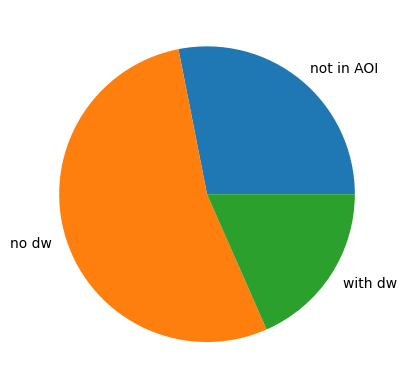

In [8]:

import matplotlib.pyplot as plt


total = 1082
outside = total-778
without = 778-199
within = 199

check = outside+without+within
if check != total:
    print("Doesn't add up")

else:

    data = [outside, without, within]
    labels = ['not in AOI', 'no dw', 'with dw']
    plt.pie(data, labels=labels)
    plt.show()

In [ ]:

import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

# ---- inputs ----
r1_path = r"/path/to/reference.tif"   # target grid/CRS
r2_path = r"/path/to/other.tif"       # will be reprojected to r1
out_diff = None

with rasterio.open(r1_path) as r1, rasterio.open(r2_path) as r2:
    a1 = r1.read(1).astype("float32")
    a2r = np.full(r1.shape, np.nan, dtype="float32")  # reprojected r2

    # nodata to NaN
    if r1.nodata is not None:
        a1[a1 == r1.nodata] = np.nan

    reproject(
        source=rasterio.band(r2, 1),
        destination=a2r,
        src_transform=r2.transform,
        src_crs=r2.crs,
        src_nodata=r2.nodata,
        dst_transform=r1.transform,
        dst_crs=r1.crs,
        dst_nodata=np.nan,
        resampling=Resampling.bilinear,  # use nearest if categorical
    )

# difference on aligned arrays
diff = a1 - a2r

# display
vmin, vmax = np.nanpercentile(diff, [2, 98])
plt.figure()
plt.imshow(diff, cmap="bwr", vmin=vmin, vmax=vmax)
plt.colorbar(label="Difference")
plt.title("Raster Difference (r1 - reprojected r2)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(diff[~np.isnan(diff)], bins=60)
plt.xlabel("Difference"); plt.ylabel("Count"); plt.title("Histogram")
plt.tight_layout()
plt.show()


if out_diff:
    with rasterio.open(r1_path) as r1:
        prof = r1.profile
    prof.update(dtype="float32", count=1, nodata=np.nan, compress="lzw")
    with rasterio.open(out_diff, "w", **prof) as dst:
        dst.write(diff, 1)


In [2]:
import json
with open('/isipd/projects/p_planetdw/data/methods_test/logs/unet_tuning/20251022-133752_unet_tuning_HB_best_hparams.json') as f:
    d=json.load(f)
    print(d)



{'tversky_alpha': 0.8, 'patch_h': 512, 'patch_w': 384, 'augmenter_strength': 0.5, 'min_pos_frac': 0.01, 'dilation_rate': 4, 'layer_count': 96, 'l2_weight': 0.0, 'dropout': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.00495588242672596}


,loss,dice_coef,accuracy,val_loss,val_dice_coef,val_accuracy,val_specificity,val_sensitivity,val_f_beta,val_f1_score,val_IoU,val_nominal_surface_distance,val_Hausdorff_distance,val_boundary_intersection_over_union,val_dice_loss,best_val_loss
0,0.093761,1.673988,0.881576,0.281979,1.993025,0.560108,0.0,0.556592,0.715094,0.715094,0.556592,0.0,0.0,0.556592,-0.992977,0.281979
1,0.065285,1.686617,0.899911,0.028668,1.995872,0.944265,0.0,0.944232,0.971311,0.971311,0.944232,0.0,0.0,0.944232,-0.995872,0.028668
2,0.061807,1.681092,0.902203,0.001733,1.996088,0.996540,0.0,0.996552,0.998268,0.998268,0.996552,0.0,0.0,0.996552,-0.996088,0.001733
3,0.059267,1.689562,0.905592,0.000000,1.996101,1.000000,0.0,1.000000,0.999995,0.999995,1.000000,0.0,0.0,1.000000,-0.996101,0.000000
4,0.062366,1.681970,0.900961,0.000025,1.996101,0.999950,0.0,0.999950,0.999970,0.999970,0.999950,0.0,0.0,0.999950,-0.996101,NaN
5,0.058552,1.686903,0.906175,0.000000,1.996101,1.000000,0.0,1.000000,0.999995,0.999995,1.000000,0.0,0.0,1.000000,-0.996101,NaN
6,0.059789,1.673704,0.905033,0.000961,1.996094,0.998081,0.0,0.998081,0.999035,0.999035,0.998081,0.0,0.0,0.998081,-0.996094,NaN
7,0.060308,1.672223,0.904654,0.001095,1.996093,0.998087,0.0,0.998030,0.999009,0.999009,0.998030,0.0,0.0,0.998030,-0.996093,NaN
8,0.061763,1.669335,0.902118,0.000000,1.996101,1.000000,0.0,1.000000,0.999995,0.999995,1.000000,0.0,0.0,1.000000,-0.996101,NaN


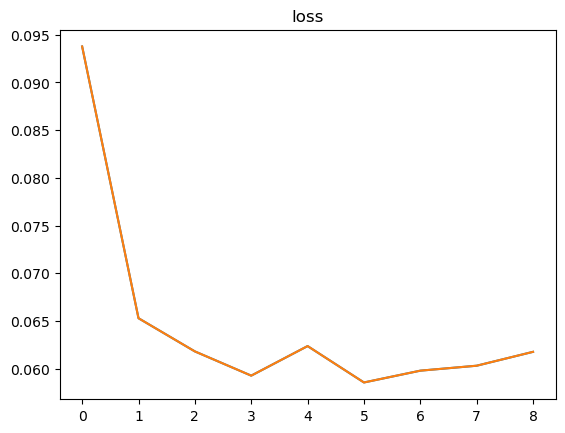

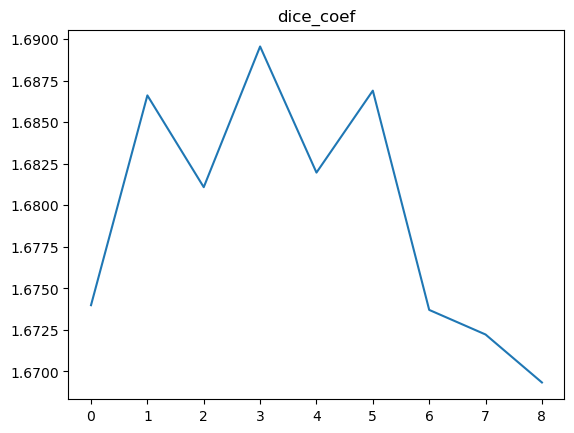

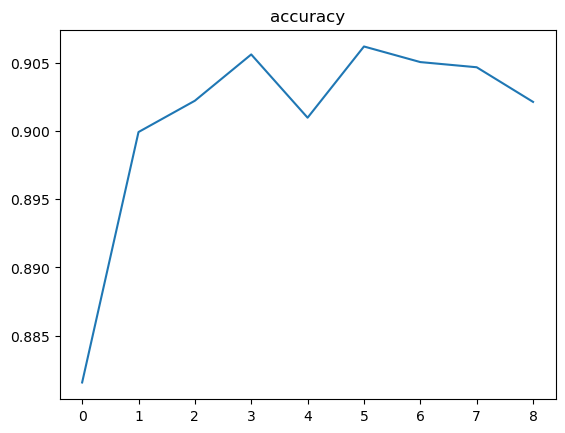

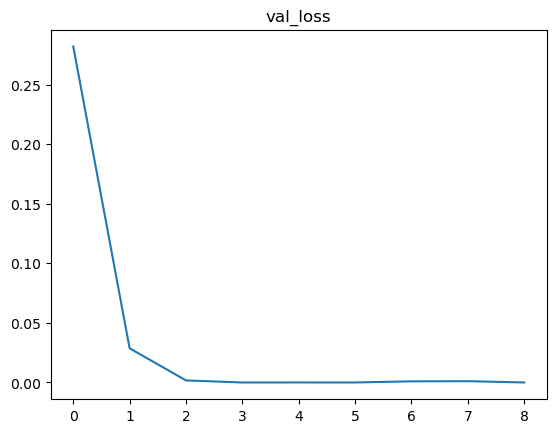

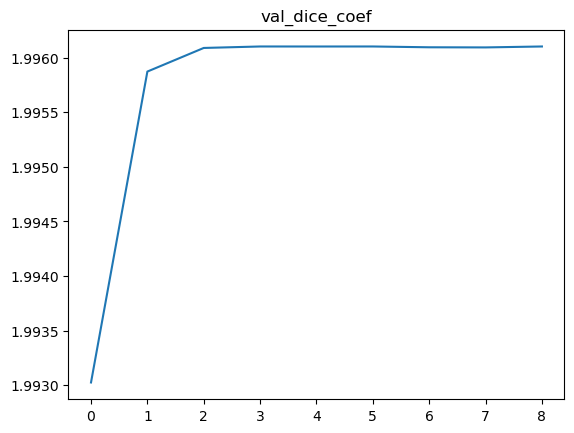

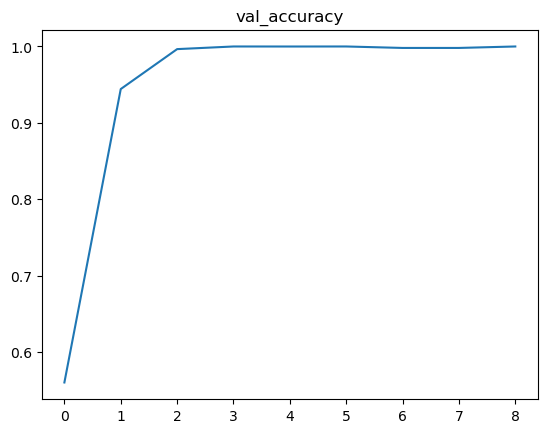

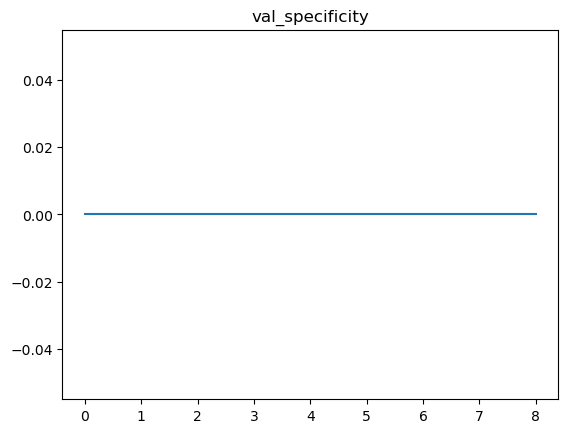

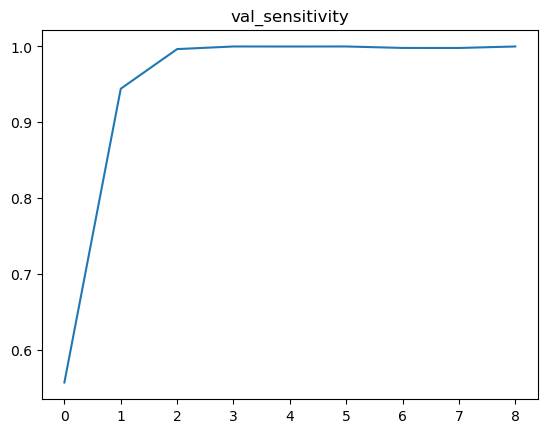

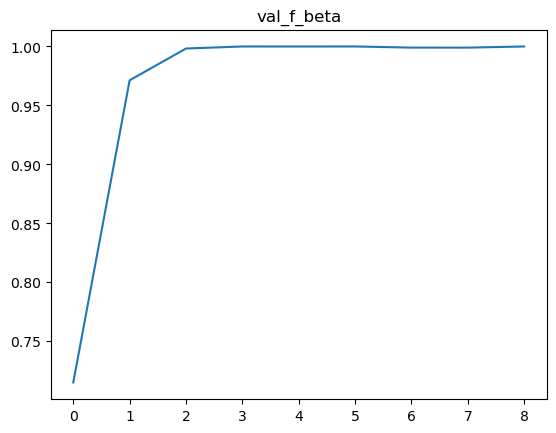

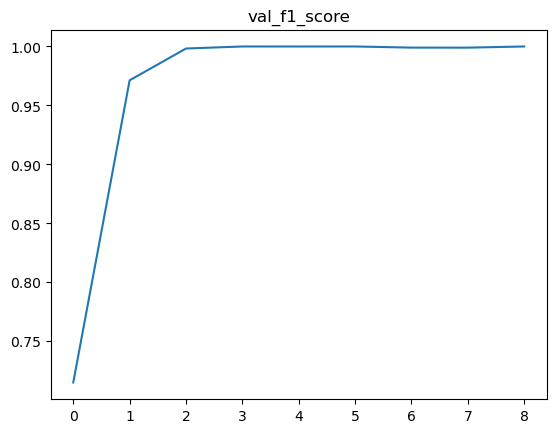

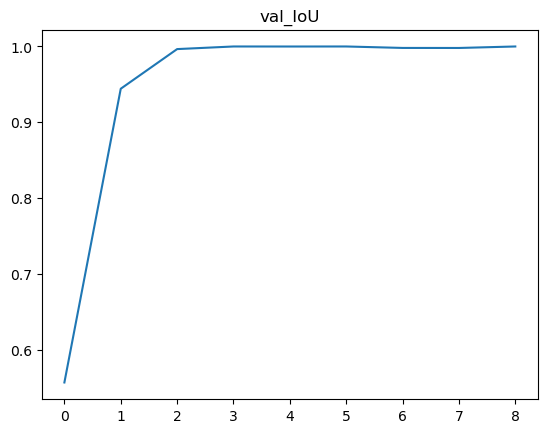

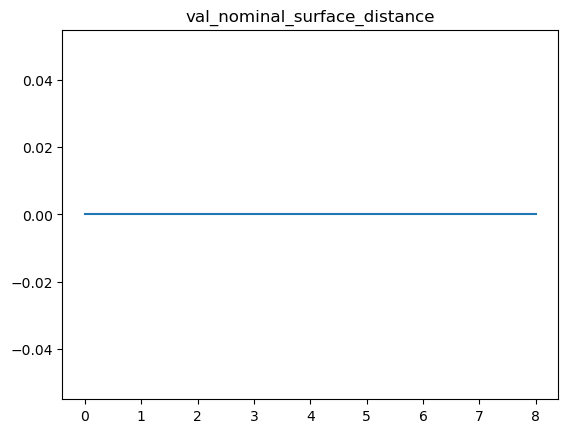

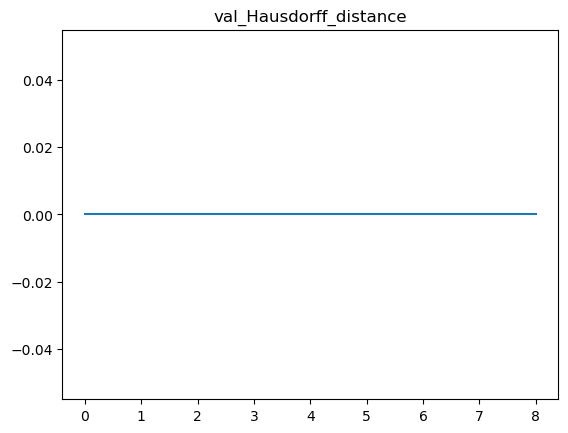

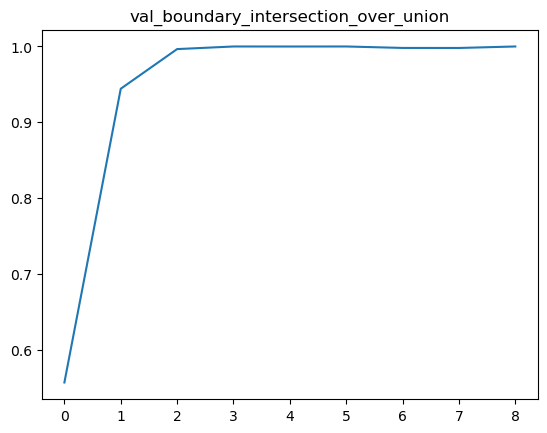

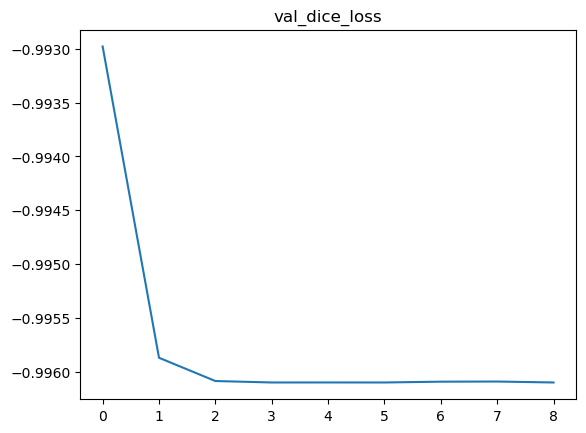

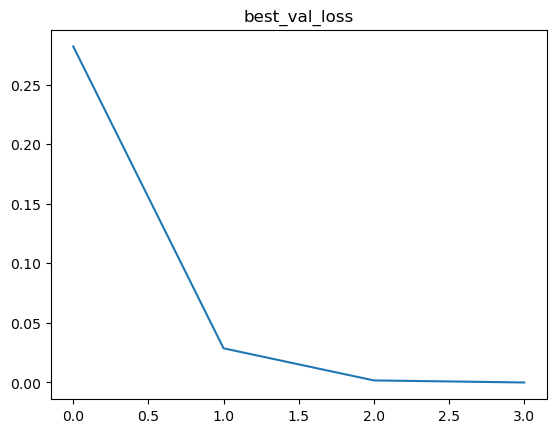

In [10]:
import pandas as pd
from matplotlib import pyplot as plt

dat = pd.read_csv(r"N:\isipd\projects\p_planetdw\data\methods_test\logs\20251022-1518_UNKtest_metrics.csv")
display(dat)
plt.plot(dat['loss'])

metrics = dat.columns

for metric in metrics:
    plt.plot(dat[f'{metric}'])
    plt.title(f'{metric}')
    plt.show()